# Overfitting and Underfitting
# 과대적합과 과소적합

- **과대적합**
    - 일정 epoch 동안 validation set이 최고점을 찍고 감소하는 경향


- **과소적합**
    - test set의 성능이 향상될 여지가 있을 때 발생
    - 원인
        - 모델이 너무 단순
        - 규제가 너무 많을 때
        - 충분히 오래 훈련하지 않은 경우



- **과대적합 및 과소적합 방지**
    - 적절한 epoch로 훈련
    - 과대적합 방지에는 더 많은 train data 추가하는 게 best(일반화 성능 향상)
    - 차선책으로는 __regulization__ 기법을 추천 → 가중치 규제, dropout등

>__Regulization__   
모델이 저장할 수 있는 정보의 양과 종류에 제약을 부과하는 방법.
네트워크가 적은 패턴만 기억 할 수 있으면 최적화 과정 동안 일반화 가능성이 가장 중요한 패턴에 초점을 맞추기 때문

## 과대적합 예제

- **가중치 규제**
    - 모델의 규모 축소(= parameter 축소)
    - 많은 parameter = 많은 기억 용량(mapping)
    - 딥러닝 모델이 train set에서는 학습이 잘되지만, 문제는 일반화
    - 적은 parameter → 손실을 최소화 하기 위해 더 많은 압축된 표현 학습이 필요
    - 가이드: 알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 **검증 손실이 감소**할 때까지 **새로운 층을 추가하거나 층의 크기를 늘리는 것**이 좋다.


 이런 기법을 사용하여 IMDB 영화 리뷰 분류 모델의 성능을 향상시켜보자.

----

## 0. 필요한 모듈 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


----
## 1. 데이터 준비

IMDB 데이터셋를 다운로드한다.  

In [3]:
NUM_WORDS = 1000
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

과대적합을 발생시키기고 어떻게 해결하는지 보이기 위해 임베딩을 사용하지 않고 여기에서는 문장을 __멀티-핫 인코딩(multi-hot encoding)__으로 변환한다. 

이 모델은 훈련 세트에 빠르게 과대적합될 것아다. 

>__멀티-핫 인코딩__  
정수 시퀀스를 0과 1로 이루어진 벡터로 변환한다. 정확하게 말하면 시퀀스 `[3, 5]`를 인덱스 3과 5만 1이고 나머지는 모두 0인 1,000 차원 벡터로 변환한다는 의미이다.

In [4]:
def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만든다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

만들어진 멀티-핫 벡터 중 하나를 살펴 보자.   

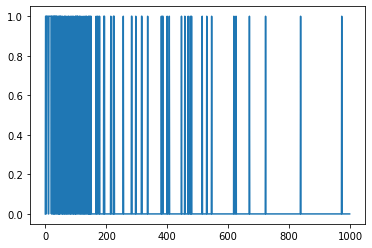

In [5]:
plt.plot(train_data[0])

단어 인덱스는 빈도 순으로 정렬되어 있다. 그래프에서 볼 수 있듯이 인덱스 0에 가까울수록 1이 많이 등장한다.

----
## 2. 기준 모델 생성

In [6]:
baseline_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6068 - accuracy: 0.6819 - binary_crossentropy: 0.6068 - val_loss: 0.4668 - val_accuracy: 0.8058 - val_binary_crossentropy: 0.4668
Epoch 2/20
49/49 - 0s - loss: 0.3868 - accuracy: 0.8374 - binary_crossentropy: 0.3868 - val_loss: 0.3496 - val_accuracy: 0.8511 - val_binary_crossentropy: 0.3496
Epoch 3/20
49/49 - 0s - loss: 0.3249 - accuracy: 0.8659 - binary_crossentropy: 0.3249 - val_loss: 0.3316 - val_accuracy: 0.8588 - val_binary_crossentropy: 0.3316
Epoch 4/20
49/49 - 0s - loss: 0.3072 - accuracy: 0.8734 - binary_crossentropy: 0.3072 - val_loss: 0.3284 - val_accuracy: 0.8599 - val_binary_crossentropy: 0.3284
Epoch 5/20
49/49 - 0s - loss: 0.3001 - accuracy: 0.8758 - binary_crossentropy: 0.3001 - val_loss: 0.3280 - val_accuracy: 0.8603 - val_binary_crossentropy: 0.3280
Epoch 6/20
49/49 - 0s - loss: 0.2932 - accuracy: 0.8790 - binary_crossentropy: 0.2932 - val_loss: 0.3286 - val_accuracy: 0.8605 - val_binary_crossentropy: 0.3286
Epoch 7/20
49/49 - 0s - loss

----
## 3. 작은 모델 생성

위에서 만든 기준 모델과 비교하기 위해 적은 수의 은닉층을 가진 모델을 생성한다.

In [8]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


같은 데이터를 사용해 모델을 훈련한다.

In [9]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6591 - accuracy: 0.5978 - binary_crossentropy: 0.6591 - val_loss: 0.6152 - val_accuracy: 0.6407 - val_binary_crossentropy: 0.6152
Epoch 2/20
49/49 - 0s - loss: 0.5800 - accuracy: 0.7285 - binary_crossentropy: 0.5800 - val_loss: 0.5524 - val_accuracy: 0.7656 - val_binary_crossentropy: 0.5524
Epoch 3/20
49/49 - 0s - loss: 0.5258 - accuracy: 0.7995 - binary_crossentropy: 0.5258 - val_loss: 0.5070 - val_accuracy: 0.8202 - val_binary_crossentropy: 0.5070
Epoch 4/20
49/49 - 0s - loss: 0.4832 - accuracy: 0.8364 - binary_crossentropy: 0.4832 - val_loss: 0.4708 - val_accuracy: 0.8349 - val_binary_crossentropy: 0.4708
Epoch 5/20
49/49 - 0s - loss: 0.4474 - accuracy: 0.8531 - binary_crossentropy: 0.4474 - val_loss: 0.4403 - val_accuracy: 0.8515 - val_binary_crossentropy: 0.4403
Epoch 6/20
49/49 - 0s - loss: 0.4169 - accuracy: 0.8639 - binary_crossentropy: 0.4169 - val_loss: 0.4158 - val_accuracy: 0.8531 - val_binary_crossentropy: 0.4158
Epoch 7/20
49/49 - 0s - loss

---
## 4. 큰 모델 생성

아주 큰 모델을 만들어 얼마나 빠르게 과대적합이 시작되는지 알아 볼 수 있다.  

이 문제에 필요한 것보다 훨씬 더 큰 용량을 가진 네트워크를 추가해서 비교해보자.

In [10]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


같은 데이터를 사용해 모델을 훈련한다.

In [11]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.4133 - accuracy: 0.8125 - binary_crossentropy: 0.4133 - val_loss: 0.3519 - val_accuracy: 0.8469 - val_binary_crossentropy: 0.3519
Epoch 2/20
49/49 - 0s - loss: 0.2886 - accuracy: 0.8789 - binary_crossentropy: 0.2886 - val_loss: 0.3398 - val_accuracy: 0.8519 - val_binary_crossentropy: 0.3398
Epoch 3/20
49/49 - 0s - loss: 0.2196 - accuracy: 0.9137 - binary_crossentropy: 0.2196 - val_loss: 0.3413 - val_accuracy: 0.8541 - val_binary_crossentropy: 0.3413
Epoch 4/20
49/49 - 0s - loss: 0.1003 - accuracy: 0.9709 - binary_crossentropy: 0.1003 - val_loss: 0.4300 - val_accuracy: 0.8476 - val_binary_crossentropy: 0.4300
Epoch 5/20
49/49 - 0s - loss: 0.0220 - accuracy: 0.9968 - binary_crossentropy: 0.0220 - val_loss: 0.6008 - val_accuracy: 0.8453 - val_binary_crossentropy: 0.6008
Epoch 6/20
49/49 - 0s - loss: 0.0051 - accuracy: 0.9996 - binary_crossentropy: 0.0051 - val_loss: 0.6324 - val_accuracy: 0.8496 - val_binary_crossentropy: 0.6324
Epoch 7/20
49/49 - 0s - loss

----
## 5. 훈련 손실과 검증 손실 그래프

실선은 훈련 손실이고 점선은 검증 손실이다.(낮은 검증 손실이 더 좋은 모델)   

여기서는 작은 네트워크가 기준 모델보다 더 늦게 과대적합이 시작되었다(즉 에포크 4가 아니라 6에서 시작). 또한 과대적합이 시작되고 훨씬 천천히 성능이 감소한다.

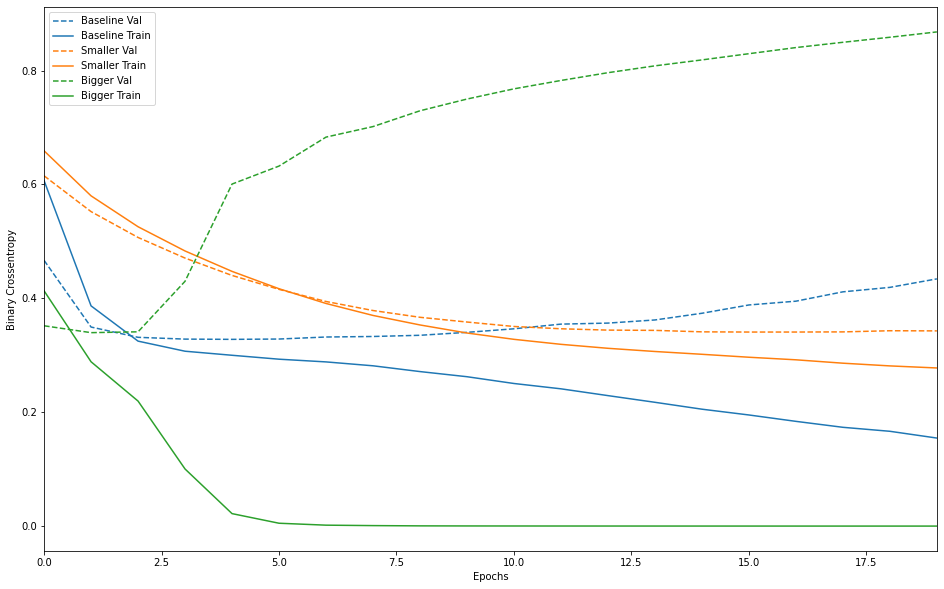

In [12]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

- 실선은 train loss, 점선은 validation loss
- validation loss가 낮다면 더 좋은 모델
- 작은모델이 기준모델보다 더 늦게 overfitting 시작, 성능도 비교적 천천히 감소
- 큰 모델은 첫 번째 epoch이후 overfitting 시작되고, 전체적으로 크게 overfitting
- 큰 모델이 더 빠르데 모델링 진행(=train loss 감소)
- 그러나 더 쉽게 overfitting(=train loss와 validation loss 사이에 큰 차이 발생)

---
## 과대적합을 방지하기  위한 전략

### 가중치를 규제하기(weight regularization)

>  **오캄의 면도날 이론(Occam's Razor)**  
어떤 것을 설명하는 두 가지 방법이 있다면 **더 정확한 설명**은 최소한의 가정이 필요한 **가장 "간단한" 설명**일 것이다.

→ 간단한 모델이 더 잘 설명 할 수 있다(=일반화, overfitting 경향이 작을 것)

- **간단한 모델?**
    - __모델 parameter 분포의 [entropy](https://ko.wikipedia.org/wiki/%EC%A0%95%EB%B3%B4_%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC)가 작은 모델__
    - 적은 parameter를 가진 모델


- **가중치 규제**
    - 네트워크 복잡도에 제약(적은 가중치를 가지도록)
    - 네트워크의 손실 함수에 큰 가중치에 해당하는 비용(cost)을 추가


- **비용함수**
    - [L1 regulatization](https://developers.google.com/machine-learning/glossary/#L1_regularization)은 가중치의 절댓값에 비례하는 비용이 추가 (즉, 가중치의 "L1 노름(norm)"을 추가).
    - [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)은 가중치의 제곱에 비례하는 비용이 추가(즉, 가중치의 "L2 노름"의 제곱을 추가)
    - L1 규제는 일부 가중치 파라미터를 0으로 만든다.
    - L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지는 않는다.  L2 규제를 더 많이 사용하는 이유 중 하나.

----
## 6. L2 Regularization 

In [13]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6181 - accuracy: 0.7113 - binary_crossentropy: 0.5752 - val_loss: 0.4777 - val_accuracy: 0.8204 - val_binary_crossentropy: 0.4371
Epoch 2/20
49/49 - 0s - loss: 0.4112 - accuracy: 0.8462 - binary_crossentropy: 0.3714 - val_loss: 0.3849 - val_accuracy: 0.8542 - val_binary_crossentropy: 0.3460
Epoch 3/20
49/49 - 0s - loss: 0.3623 - accuracy: 0.8649 - binary_crossentropy: 0.3244 - val_loss: 0.3688 - val_accuracy: 0.8600 - val_binary_crossentropy: 0.3319
Epoch 4/20
49/49 - 0s - loss: 0.3463 - accuracy: 0.8726 - binary_crossentropy: 0.3102 - val_loss: 0.3648 - val_accuracy: 0.8608 - val_binary_crossentropy: 0.3296
Epoch 5/20
49/49 - 0s - loss: 0.3398 - accuracy: 0.8750 - binary_crossentropy: 0.3053 - val_loss: 0.3639 - val_accuracy: 0.8602 - val_binary_crossentropy: 0.3301
Epoch 6/20
49/49 - 0s - loss: 0.3359 - accuracy: 0.8765 - binary_crossentropy: 0.3027 - val_loss: 0.3608 - val_accuracy: 0.8602 - val_binary_crossentropy: 0.3281
Epoch 7/20
49/49 - 0s - loss

L2 Regularization 의 효과를 확인해보자.

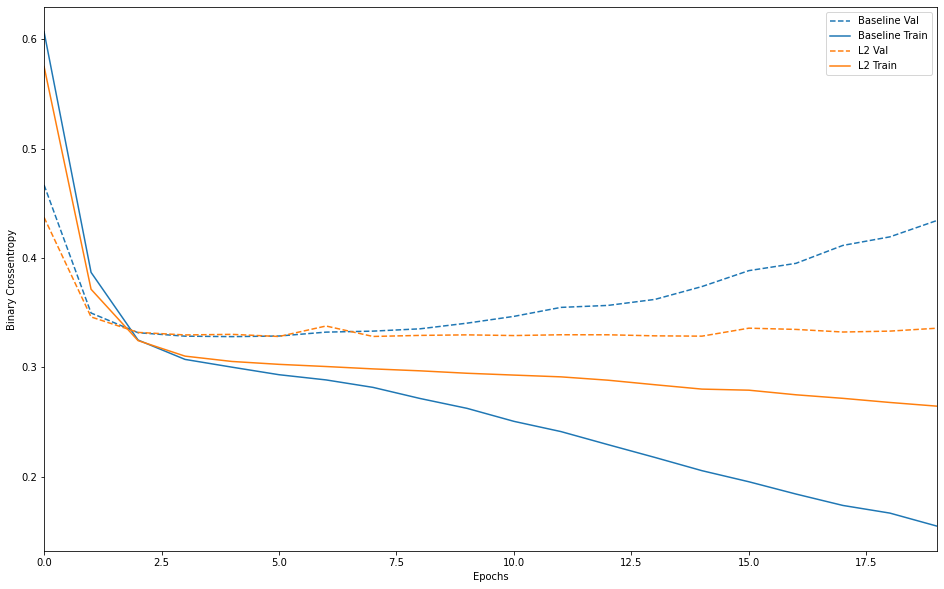

In [14]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

결과에서 보듯이 모델 파라미터의 개수는 같지만 L2 규제를 적용한 모델이 기본 모델보다 과대적합에 훨씬 잘 견디고 있다.

----
## 7. 드롭아웃 (Dropout)

__드롭아웃__ 은
- 훈련하는 동안 레이어의 출력 특성을 랜덤하게 끈다(=0으로 만든다)
- [0.2, 0.5, 1.3, 0.8, 1.1] → [0, 0.5, 1.3, 0, 1.1]
- 비율은 보통 0.2에서 0.5 사이 사용
- 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않지만
- 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄인다.

In [16]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Epoch 1/20
49/49 - 1s - loss: 0.6773 - accuracy: 0.5635 - binary_crossentropy: 0.6773 - val_loss: 0.6019 - val_accuracy: 0.7559 - val_binary_crossentropy: 0.6019
Epoch 2/20
49/49 - 0s - loss: 0.5819 - accuracy: 0.6925 - binary_crossentropy: 0.5819 - val_loss: 0.4647 - val_accuracy: 0.8246 - val_binary_crossentropy: 0.4647
Epoch 3/20
49/49 - 0s - loss: 0.4931 - accuracy: 0.7629 - binary_crossentropy: 0.4931 - val_loss: 0.3876 - val_accuracy: 0.8452 - val_binary_crossentropy: 0.3876
Epoch 4/20
49/49 - 0s - loss: 0.4452 - accuracy: 0.7974 - binary_crossentropy: 0.4452 - val_loss: 0.3581 - val_accuracy: 0.8509 - val_binary_crossentropy: 0.3581
Epoch 5/20
49/49 - 0s - loss: 0.4167 - accuracy: 0.8172 - binary_crossentropy: 0.4167 - val_loss: 0.3419 - val_accuracy: 0.8553 - val_binary_crossentropy: 0.3419
Epoch 6/20
49/49 - 0s - loss: 0.3960 - accuracy: 0.8314 - binary_crossentropy: 0.3960 - val_loss: 0.3316 - val_accuracy: 0.8560 - val_binary_crossentropy: 0.3316
Epoch 7/20
49/49 - 0s - loss

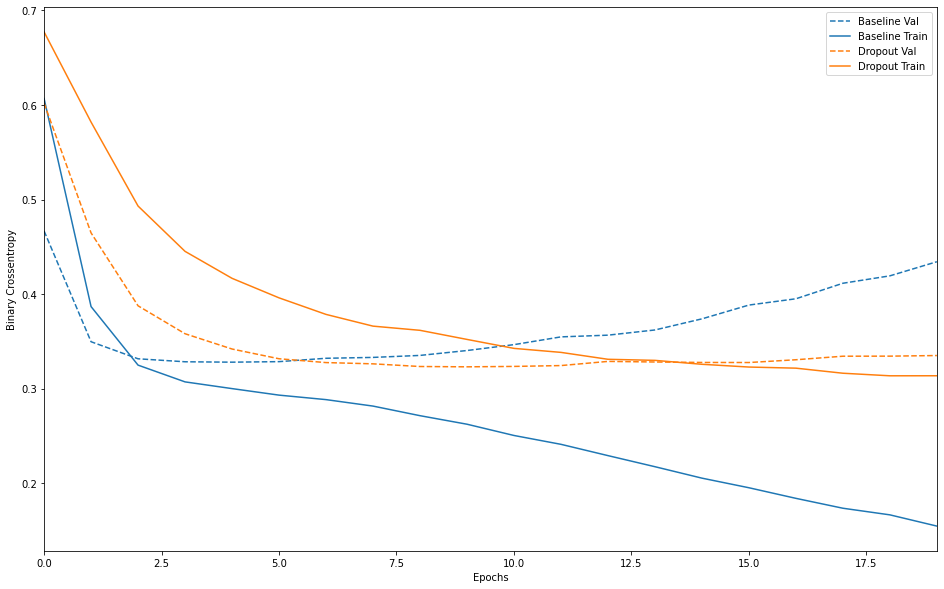

In [17]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

기준 모델보다 향상된 결과를 확인할 수 있다.

____
## 정리

정리하면 신경망에서 overfitting 방지를 위한 방법은 다음과 같다.

- 더 많은 훈련 데이터를 추가
- 네트워크의 용량을 감소
- 가중치 규제를 추가
- 드롭아웃을 추가

데이터 증식(data-augmentation)과 배치 정규화(batch normalization)는 여기서 다루지 않았음